# NBA Matches

## Objetivo

Considerando o crescente uso de ciência dos dados no mercardo esportivo e de especulação, nesta semana vocês farão parte de uma startup que quer quebrar os sites de apostas da NBA!

O mercado online de apostas foi avaliado em US$85.047 no ano de 2019 e pode ter um crescimento ainda maior nos próximos anos levando em consideração a posição favorável de alguns governos com a legalização das plataformas e pagamento de impostos. [1]

Com isso, a startup de vocês, RodaRodaBet, após um estudo inicial sobre o mercado de apostas americano e dos dados disponíveis online sobre a NBA [2], está buscando a construção de um modelo que possa indicar se os times da casa irão ganhar ou perder em cada rodada da liga.

Neste desafio, vocês irão utilizar dados raspados da NBA & ABA League Index, que contém informações sobre os times que jogam em cada rodada da NBA, para prever se determinado time da casa vai ganhar ou perder (Win or Lose).

References:

1 - https://www.globenewswire.com/news-release/2020/08/31/2086041/0/en/Global-Sports-Betting-Market-Worth-85-Billion-in-2019-Industry-Assessment-and-Forecasts-Throughout-2020-2025.html

2 - https://towardsdatascience.com/predicting-the-2020-nba-playoffs-bracket-with-machine-learning-2030f80fa62c

3 - https://www.basketball-reference.com/leagues/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(2021)

In [2]:
df_test= pd.read_csv("test_without_label.csv")
df_train = pd.read_csv("train_full.csv")

## Entendendo os dados

Pelo fato das variáveis serem as estatísticas dos jogos e por termos bastantes variáveis nesse sentido, optamos por não criar novas variáveis a partir delas. Decidimos investir na variável data. Observamos que a variável dia do ano foi bastante importante para os modelos testados e a partir disso, criamos outras variações, como dias da semana, dias do mês, entre outros.

### Porcentagem de dados jogos vencidos e jogos perdidos

In [3]:
# remove espaço nos nomes das colunas
df_train.columns = df_train.columns.str.strip()
df_test.columns = df_test.columns.str.strip()

In [4]:
df_train.WinOrLose.value_counts()

L    654
W    352
Name: WinOrLose, dtype: int64

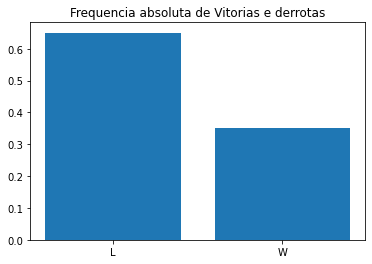

In [5]:
y = df_train.WinOrLose.value_counts()/df_train.WinOrLose.value_counts().sum() #frequencia absoluta
plt.bar(['L','W'],y)
plt.title('Frequencia absoluta de Vitorias e derrotas')
plt.show()

Temos uma grande maioria de jogos perdidos, portanto eh necessario uma analise estratificada quando for treinar os modelos

In [6]:
df_train.head()

,Game,Data,H_Team,H_Wins,H_Loss,H_W/D %,H_SRS,H_Games,H_TotalPoints,H_AvgPointsPerGame,...,A_TS%,A_eFG%,A_TOV%,A_ORB%,A_FT/FGA,A_OeFG%,A_OTOV%,A_DRB%,A_OFT/FGA,WinOrLose
0,0,"Thu, June 8",Miami Heat,52,30,0.634,3.59,82,8191,99.9,...,0.550,0.495,13.1,31.8,0.285,0.475,13.7,72.2,0.257,L
1,1,"Sun, June 11",Miami Heat,52,30,0.634,3.59,82,8191,99.9,...,0.550,0.495,13.1,31.8,0.285,0.475,13.7,72.2,0.257,L
2,2,"Tue, June 13",Dallas Mavericks,60,22,0.732,5.96,82,8130,99.1,...,0.556,0.517,13.9,26.7,0.254,0.477,12.4,76.4,0.251,L
3,3,"Thu, June 15",Dallas Mavericks,60,22,0.732,5.96,82,8130,99.1,...,0.556,0.517,13.9,26.7,0.254,0.477,12.4,76.4,0.251,L
4,4,"Sun, June 18",Dallas Mavericks,60,22,0.732,5.96,82,8130,99.1,...,0.556,0.517,13.9,26.7,0.254,0.477,12.4,76.4,0.251,L


## Pre-processamento

### Tratando as datas

In [7]:
treino = df_train
teste  = df_test

In [8]:
from datetime import datetime

# Na base de teste
for i in range(0, teste.shape[0]):
  teste['Data'].iloc[i] = datetime.strptime(teste['Data'].iloc[i], '%a, %B %d')
  teste['Data'].iloc[i] = datetime.strftime(teste['Data'].iloc[i], '%m-%d')

teste['Data'] = pd.to_datetime(teste['Data'], format="%m-%d", errors='raise')

#base de treino
for i in range(0, treino.shape[0]):
  treino['Data'].iloc[i] = datetime.strptime(treino['Data'].iloc[i], '%a, %B %d')
  treino['Data'].iloc[i] = datetime.strftime(treino['Data'].iloc[i], '%m-%d')

treino['Data'] = pd.to_datetime(treino['Data'], format="%m-%d", errors='raise')

C:\Users\msini\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## Criacao de algumas features com data

In [9]:
teste['Dia'] = teste.Data.dt.day
treino['Dia'] = treino.Data.dt.day

teste['Dia'] = teste.Data.dt.day
treino['Dia'] = treino.Data.dt.day

teste['weekday'] = teste.Data.dt.weekday
treino['weekday'] = treino.Data.dt.weekday

teste['weekofyear'] = teste.Data.dt.weekofyear
treino['weekofyear'] = treino.Data.dt.weekofyear

teste['Dia do Ano'] = teste.Data.dt.dayofyear
treino['Dia do Ano'] = treino.Data.dt.dayofyear

<ipython-input-9-c7af2d33b494>:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  teste['weekofyear'] = teste.Data.dt.weekofyear
<ipython-input-9-c7af2d33b494>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  treino['weekofyear'] = treino.Data.dt.weekofyear


### Análise exploratória (Variáveis de datas)

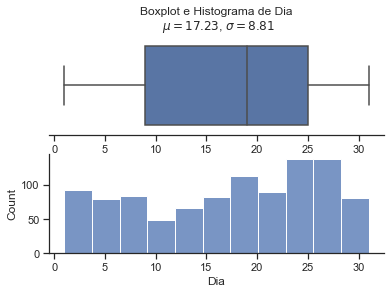

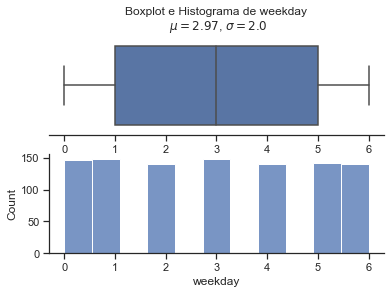

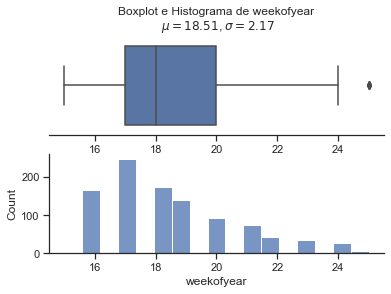

In [10]:
vars_dias = ['Dia', 'weekday', 'weekofyear']

for i in vars_dias:

  sns.set(style="ticks")

  x = treino[i]
  coluna = i
  mu = round(x.mean(),2) # mean of distribution
  sigma = round(x.std(),2)  # standard deviation of distribution

  f, (ax_box, ax_hist) = plt.subplots(2)

  sns.boxplot(x=x, ax=ax_box)
  sns.histplot(x=x, ax=ax_hist)

  ax_box.set(yticks=[])
  sns.despine(ax=ax_hist)
  sns.despine(ax=ax_box, left=True)
  ax_box.set_title('Boxplot e Histograma de {}\n $\mu={}$, $\sigma={}$'.format(coluna, mu,sigma))

plt.show()

Weekofyear e Dia do ano possuem um formato de distribuição próximo.

### Gráfico de barras (variáveis de datas)

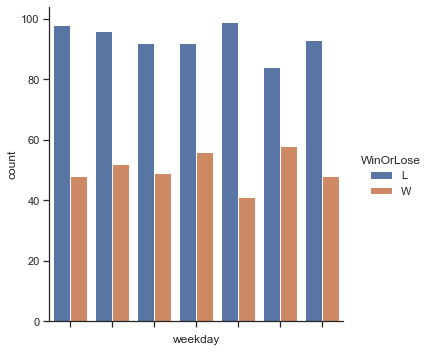

In [11]:
visu = sns.catplot(x = 'weekday', data = treino, hue ='WinOrLose', kind = 'count', margin_titles = True)
visu.set(xticklabels=[])
plt.show()

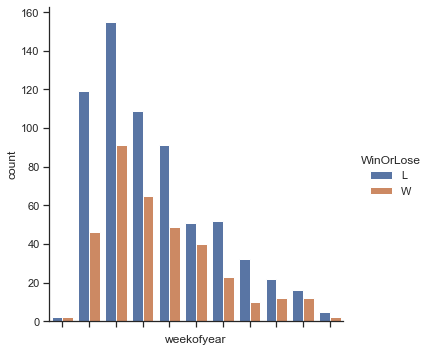

In [12]:
visu = sns.catplot(x = 'weekofyear', data = treino, hue ='WinOrLose', kind = 'count', margin_titles = True)
visu.set(xticklabels=[])
plt.show()

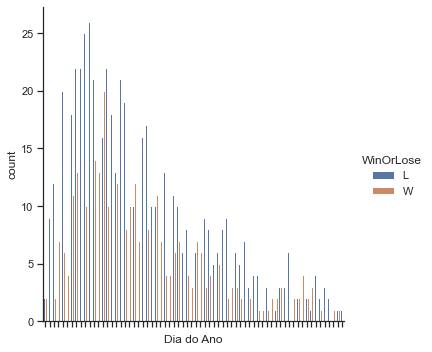

In [13]:
visu = sns.catplot(x = 'Dia do Ano', data = treino, hue ='WinOrLose', kind = 'count', margin_titles = True)
visu.set(xticklabels=[])
plt.show()

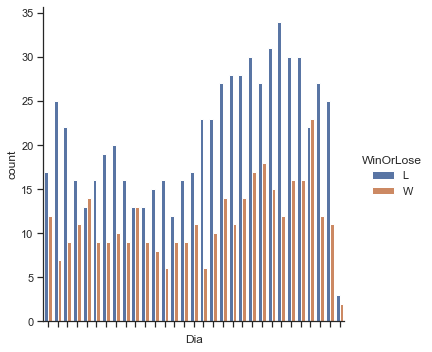

In [14]:
visu = sns.catplot(x = 'Dia', data = treino, hue ='WinOrLose', kind = 'count', margin_titles = True)
visu.set(xticklabels=[])
plt.show()

### Criacao da feature season (estacao do ano: Primavera, verão, outono e inverno)

lembrar que nos EUA as estacoes do ano sao diferentes

In [15]:
teste['Season'] = teste.Data.dt.month%12 // 3 + 1
treino['Season'] = treino.Data.dt.month%12 // 3 + 1

In [16]:
print(teste['Season'].value_counts())
print(treino['Season'].value_counts())

teste_total = teste.copy()

2    77
3    47
4    41
Name: Season, dtype: int64
2    924
3     82
Name: Season, dtype: int64


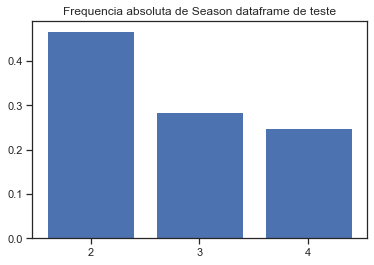

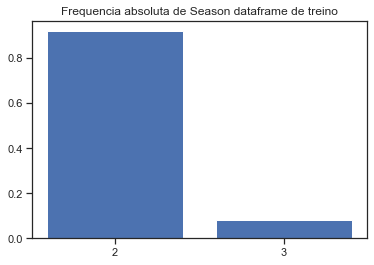

In [17]:
y = teste['Season'].value_counts()/teste['Season'].value_counts().sum() #frequencia absoluta
plt.bar(['2','3','4'],y)
plt.title('Frequencia absoluta de Season dataframe de teste')
plt.show()

y = treino['Season'].value_counts()/treino['Season'].value_counts().sum() #frequencia absoluta
plt.bar(['2','3'],y)
plt.title('Frequencia absoluta de Season dataframe de treino')
plt.show()

Note que os jogos acontecem exclusivamente nas seasons 2, 3 e 4 e veja que no treino temos quase que exclusivamente os jogos acontecendo na season 2, indicando que essa variável talvez não seja muito interessantes para os modelos.

### Retirando a coluna Game

In [18]:
#teste
Id = teste.Game #sera utilizado para prever depois
teste = teste.iloc[:,1:]

#treino
treino = treino.iloc[:,1:]

### Retirando a coluna Date

In [19]:
teste.drop('Data', axis=1, inplace= True)

treino.drop('Data', axis=1, inplace= True)

### Transformando os dados do tipo object 'O' para tipo int

In [20]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
#base de treino
for i in range(0, len(treino.columns.values)):
  if treino.dtypes[i] == 'O':
    treino.iloc[:, i] = le.fit_transform(treino.iloc[:, i]).astype('int')

#Na base de test
for i in range(0, len(teste.columns.values)):
  if teste.dtypes[i] == 'O':
    teste.iloc[:, i] = le.fit_transform(teste.iloc[:, i]).astype('int')

## Feature Selection

### Feature Importance (Random Forest)

In [21]:
#Divide the features into Independent and Dependent Variable
X = treino.drop('WinOrLose' , axis =1)
X_completo = X
y = treino['WinOrLose']
y_completo = y.copy()

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

colunas = X.columns
scaler_train = StandardScaler()
#scaler_train = MinMaxScaler()
X = scaler_train.fit_transform(X)

#Nao precisa padronizar o teste pq estamos apenas vendo as features de importancia

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.25)
model  = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [24]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,25))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

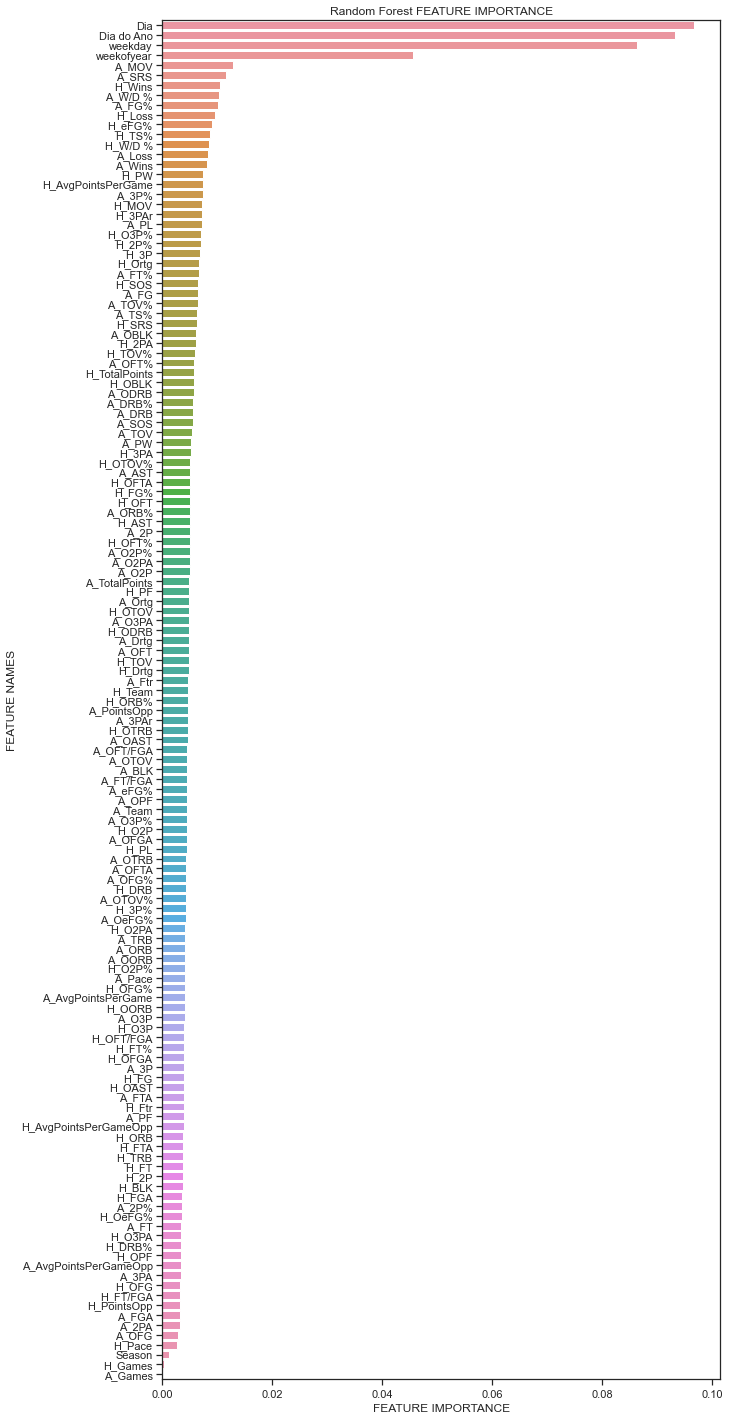

In [25]:
plot_feature_importance(model.feature_importances_,colunas,'Random Forest ')

### Selecionando k colunas por ordem de importancia

In [26]:
    #Create arrays from feature importance and feature names
    importance = model.feature_importances_
    names = colunas

    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    #Resetando os index para poder selecionar as colunas desejadas
    fi_df.reset_index(inplace=True)
    #Selecionando o numero de colunas que deseja, por ordem de importancia
    select_colunas = fi_df.feature_names[0:14]

In [27]:
list(select_colunas)

['Dia',
 'Dia do Ano',
 'weekday',
 'weekofyear',
 'A_MOV',
 'A_SRS',
 'H_Wins',
 'A_W/D %',
 'A_FG%',
 'H_Loss',
 'H_eFG%',
 'H_TS%',
 'H_W/D %',
 'A_Loss']

In [28]:
treino_completo = treino.copy()
teste_completo = teste.copy()

treino = treino[select_colunas]

teste = teste[select_colunas]

In [29]:
treino.head()

,Dia,Dia do Ano,weekday,weekofyear,A_MOV,A_SRS,H_Wins,A_W/D %,A_FG%,H_Loss,H_eFG%,H_TS%,H_W/D %,A_Loss
0,8,159,4,23,6.07,5.96,52,0.732,0.462,30,0.517,0.556,0.634,22
1,11,162,0,24,6.07,5.96,52,0.732,0.462,30,0.517,0.556,0.634,22
2,13,164,2,24,3.87,3.59,60,0.634,0.478,22,0.495,0.550,0.732,30
3,15,166,4,24,3.87,3.59,60,0.634,0.478,22,0.495,0.550,0.732,30
4,18,169,0,25,3.87,3.59,60,0.634,0.478,22,0.495,0.550,0.732,30


## EDA

### Correlation Heatmap

<ipython-input-30-4aa79b6928d7>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(treino.corr(), dtype=np.bool))


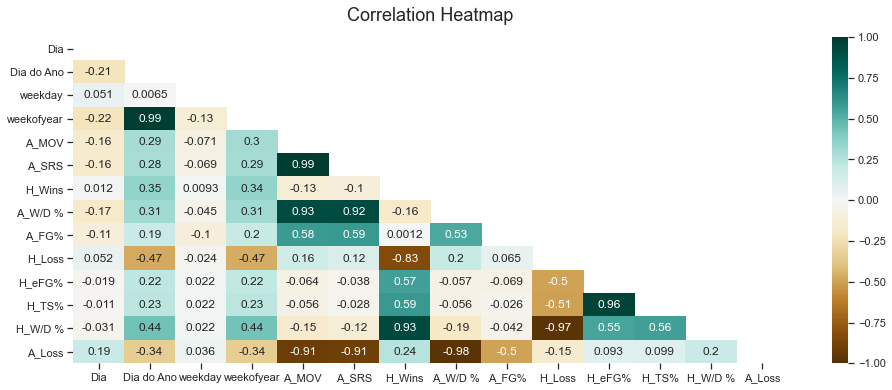

In [30]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(treino.corr(), dtype=np.bool))
heatmap = sns.heatmap(treino.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [31]:
print(treino.shape)
print(y.shape)

(1006, 14)
(1006,)


Através das 14 primeiras variáveis selecionadas (apenas com a variável dia do ano, sem as outras derivações da Data), utilizamos o método de seleção forward para encontrar o melhor subconjunto de forma a obtermos o melhor resultado, considerando a métrica curva roc. Após observarmos qual foi o melhor subconjunto, fomos eliminando aquelas variáveis que estavam correlacionadas com alguma outra variável. Fizemos isso considerando apenas a variável Dia do Ano na hora de rodar o modelo randon forest (eliminando as outras variações da variável data) e obtivemos como melhores características, através do modelo Naive Bayes, as seguintes variáveis: 
'Dia do Ano', 'A_W/D %', 'A_FG%', 'H_MOV', 'H_eFG%', 'A_3P%', 'A_FT%'. Resultando no Score do Kaggle 0.727

Da mesma forma, fizemos o mesmo procedimento testando as outras variações das variáveis a partir da Data, eliminando a variável Dia do Ano, e obtivemos como melhores variáveis para o modelo de Naive Bayes: 'Dia', 'weekday', 'weekofyear', 'H_eFG%','A_W/D %', 'A_SRS'. E essas variáveis resultaram no melhor score do Kaggle: 0.729

Será reproduzido os resultados para a melhor acurácia que obtivemos no teste e que resultou na melhor classificação do kaggle.

## Padronização e Train test split

In [32]:
#As 14 melhores variáveis escolhidas pelo modelo random forest sem a variável dia do Ano
#col = ['Dia', 'weekday', 'weekofyear', 'A_Loss', 'H_eFG%', 'H_MOV', 'A_W/D %', 'H_SRS', 'A_MOV', 'A_Wins', 'A_SRS', 'H_TS%', 'H_W/D %', 'H_Loss']

treino = X_completo[select_colunas]
teste = teste_completo

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler_train = StandardScaler()
#scaler_train = MinMaxScaler()
X = scaler_train.fit_transform(treino)

#Vamos padronizar o teste tbm
scaler_train = StandardScaler()
#scaler_train = MinMaxScaler()
teste = scaler_train.fit_transform(teste[select_colunas])

In [34]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.25)


In [36]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score

from mlxtend.feature_selection import SequentialFeatureSelector

feature_selector = SequentialFeatureSelector(RandomForestClassifier(n_jobs=-1),
           k_features = 14,
           forward = True,
           verbose = 2,
           scoring = 'roc_auc',
           cv = 5)

In [37]:
# o subconjunto formado por 8 variáveis foi o escolhido: score: 0.615483
features = feature_selector.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   18.2s finished

[2021-10-09 17:31:45] Features: 1/14 -- score: 0.5970483694203371[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:   13.1s finished

[2021-10-09 17:31:58] Features: 2/14 -- score: 0.5919707650839727[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   12.4s finished

[2021-10-09 17:32:10] Features: 3/14 -- score: 0.5784259204407453[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [38]:
features.subsets_

{1: {'feature_idx': (7,),
  'cv_scores': array([0.55236812, 0.67404698, 0.64054678, 0.5790335 , 0.53924647]),
  'avg_score': 0.5970483694203371,
  'feature_names': ('7',)},
 2: {'feature_idx': (7, 13),
  'cv_scores': array([0.54331921, 0.65941471, 0.64372353, 0.57787832, 0.53551805]),
  'avg_score': 0.5919707650839727,
  'feature_names': ('7', '13')},
 3: {'feature_idx': (1, 7, 13),
  'cv_scores': array([0.57691567, 0.5883712 , 0.61676935, 0.60271467, 0.50735871]),
  'avg_score': 0.5784259204407453,
  'feature_names': ('1', '7', '13')},
 4: {'feature_idx': (1, 7, 10, 13),
  'cv_scores': array([0.57653061, 0.55650751, 0.6380439 , 0.62726223, 0.55788854]),
  'avg_score': 0.5912465566778236,
  'feature_names': ('1', '7', '10', '13')},
 5: {'feature_idx': (1, 2, 7, 10, 13),
  'cv_scores': array([0.59655372, 0.53744705, 0.68569503, 0.61994609, 0.59193485]),
  'avg_score': 0.6063153490714137,
  'feature_names': ('1', '2', '7', '10', '13')},
 6: {'feature_idx': (1, 2, 3, 7, 10, 13),
  'cv_sco

In [39]:
#O melhor subconjunto foi: ['Dia', 'weekday', 'weekofyear', 'A_Loss', 'H_eFG%', 'A_W/D %', 'A_Wins', 'A_SRS']
cols = ['Dia', 'weekday', 'weekofyear', 'A_Loss', 'H_eFG%', 'A_W/D %', 'A_Wins', 'A_SRS'] 
treino = X_completo
treino = treino[cols]

<ipython-input-40-4aa79b6928d7>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(treino.corr(), dtype=np.bool))


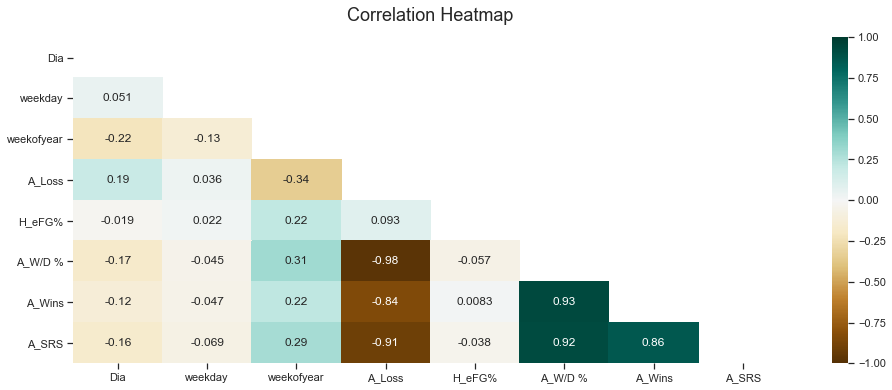

In [40]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(treino.corr(), dtype=np.bool))
heatmap = sns.heatmap(treino.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

Através das correlações, optamos por eliminar as variáveis 'A_Loss' e 'A_Wins'

In [41]:
col = ['Dia', 'weekday', 'weekofyear', 'H_eFG%','A_W/D %', 'A_SRS']
treino = X_completo[col]
teste = teste_completo

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler_train = StandardScaler()
#scaler_train = MinMaxScaler()
X = scaler_train.fit_transform(treino)

#Vamos padronizar o teste tbm
scaler_train = StandardScaler()
#scaler_train = MinMaxScaler()
teste = scaler_train.fit_transform(teste[col])

#treino e validação
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.25)


## Naive Bayes

In [43]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.naive_bayes import GaussianNB # 1. choose model class
model_NB = GaussianNB()                       # 2. instantiate model
model_NB.fit(X_train, y_train)                # 3. fit model to data
y_predNB = model_NB.predict(X_test)            # 4. predict on new data

# calcula a acuracia

print('Acuracia Naivy bayes: {:.3f}'.format(balanced_accuracy_score(y_predNB, y_test)))
print("F1 score Naivy bayes: {:.3f}".format(f1_score(y_test, y_predNB, average = "weighted")))
print("Precision Naivy bayes: {:.3f}".format(precision_score(y_test, y_predNB, average = "weighted")))

Acuracia Naivy bayes: 0.632
F1 score Naivy bayes: 0.655
Precision Naivy bayes: 0.656


In [44]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model_NB, X_train, y_train, cv=10)

print(cv_scores)
print("Media Cross-val accuracy: %f" % cv_scores.mean())
print("Variância: %f" % cv_scores.var())

[0.68421053 0.68421053 0.69736842 0.67105263 0.73333333 0.65333333
 0.72       0.66666667 0.62666667 0.65333333]
Media Cross-val accuracy: 0.679018
Variância: 0.000930


In [45]:
from sklearn.model_selection import cross_validate

#cv = cross_validate(model_NB, X_train, y_train, return_train_score=True)
cv = cross_validate(model_NB, X, y, return_train_score=True, cv=10)

print(cv['test_score'].mean())
print(cv['train_score'].mean())

0.667950495049505
0.6770484065712926


## SVM


In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

#Hiper parâmetros para otimizacao
C = np.arange(1,30)
gamma = ["scale", "auto"]
decision_function_shape = ["ovo", "ovr"]
k_fold = 10
#GridSearch para achar a melhor combinação de valores dos hiper parâmetros.
#   aplicando ainda uma validação cruzada com 10 folds.
model_svm = GridSearchCV(SVC(), cv = k_fold,
                     param_grid={"C": C, "gamma": gamma, "decision_function_shape": decision_function_shape})
model_svm.fit(X_train, y_train)
y_pred = model_svm.predict(X_test)



#Mensurar a qualidade do modelo ajustado
print("Acurácia SVM: {:.3f}".format(balanced_accuracy_score(y_test, y_pred)))
print("F1 score SVM: {:.3f}".format(f1_score(y_test, y_pred, average = "weighted")))
print("Precision SVM: {:.3f}".format(precision_score(y_test, y_pred, average = "weighted")))

Acurácia SVM: 0.574
F1 score SVM: 0.629
Precision SVM: 0.629


In [47]:
#SVM 
from sklearn.model_selection import cross_validate
cv = cross_validate(model_svm.best_estimator_, X, y, return_train_score=True, cv=10)
print(cv['test_score'].mean())
print(cv['train_score'].mean())

0.6252871287128713
0.7168105813910943


## Submetendo NB

In [48]:
y_pred = model_NB.predict(teste)
y_pred = np.array(y_pred, dtype = int)

prediction = pd.DataFrame()
prediction['Game'] = Id
prediction['WinOrLose'] = y_pred
prediction['WinOrLose']

d = {1: 'W', 0: 'L'}
prediction['WinOrLose'].replace(d,inplace = True)

In [49]:
prediction.head()

,Game,WinOrLose
0,0,W
1,1,W
2,2,L
3,3,L
4,4,W


In [50]:
prediction['WinOrLose'].value_counts()

L    130
W     35
Name: WinOrLose, dtype: int64

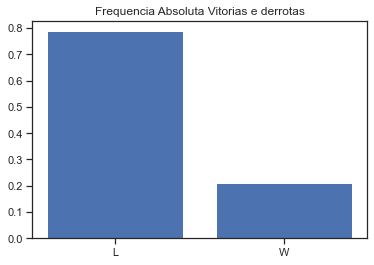

In [51]:
y = prediction['WinOrLose'].value_counts()/prediction.WinOrLose.value_counts().sum()
plt.bar(['L','W'],y)
plt.title('Frequencia Absoluta Vitorias e derrotas')
plt.show()

In [52]:
prediction.to_csv('NB.csv', index = False)

**Score no Kaggle: 0.729**

## Submetendo SVM

In [53]:
y_pred = model_svm.predict(teste)
y_pred = np.array(y_pred, dtype = int)

prediction = pd.DataFrame()
prediction['Game'] = Id
prediction['WinOrLose'] = y_pred
prediction['WinOrLose']

d = {1: 'W', 0: 'L'}
prediction['WinOrLose'].replace(d,inplace = True)

In [54]:
prediction.head()

,Game,WinOrLose
0,0,L
1,1,L
2,2,L
3,3,L
4,4,L


In [55]:
prediction['WinOrLose'].value_counts()

L    136
W     29
Name: WinOrLose, dtype: int64

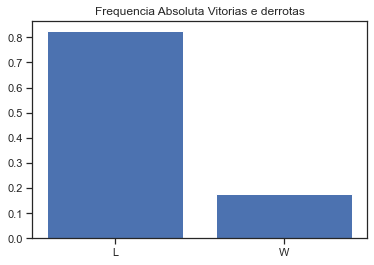

In [56]:
y = prediction['WinOrLose'].value_counts()/prediction.WinOrLose.value_counts().sum()
plt.bar(['L','W'],y)
plt.title('Frequencia Absoluta Vitorias e derrotas')
plt.show()

In [57]:
prediction.to_csv('SVM.csv', index = False)